<a href="https://colab.research.google.com/github/Raoufmamedov/various_studies/blob/main/Churn%20study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Изучение оттока клиентов банка

## Введение

### Постановка задачи

В нашем распоряжении находятся данные об оттоке клиентов международного банка, и наша задача — разработать программу лояльности для удержания клиентов. Для этого необходимо выявить факторы, связанные с уходом клиентов, сравнив профили лояльных и ушедших пользователей. После проведения разведывательного анализа мы постараемся выделить статистически значимые признаки и построить модель машинного обучения, способную прогнозировать вероятность оттока клиентов.

### Подготовительные действия

В работе мы будем использовать библиотеки Pandas, Marplotlib, Seaborn Plotly. Загружаем данные и библиотеки для их обработки

In [149]:
!pip install optuna

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import plotly.express as ex
import warnings
import lightgbm as lgb
import optuna
import joblib
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, chi2_contingency

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Знакомство с датасетом

In [152]:
import pandas as pd
churn_df=pd.read_csv('/content/drive/MyDrive/churn.csv')

display(churn_df.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


 Посмотрим, имеются ли пропуски в данных

In [153]:
display('Количество пропусков:', pd.DataFrame(churn_df.isna().sum().reset_index()).set_index('index').T)
churn_df.info()

'Количество пропусков:'

index,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Итак, у нас имеются записи по 10000 клиентам и следующие 14 признаков (целевой признак Exited и 13 предикторов):

    * RowNumber — номер строки таблицы (это лишняя информация, поэтому можете сразу от неё избавиться)
    * CustomerId — идентификатор клиента
    * Surname — фамилия клиента
    * CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их)
    * Geography — страна клиента (банк международный)
    * Gender — пол клиента
    * Age — возраст клиента
    * Tenure — сколько лет клиент пользуется услугами банка
    * Balance — баланс на счетах клиента в банке
    * NumOfProducts — количество услуг банка, которые приобрёл клиент
    * HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет)
    * IsActiveMember — есть ли у клиента статус активного клиента банка (1 — да, 0 — нет)
    * EstimatedSalary — предполагаемая заработная плата клиента
    * Exited — статус лояльности (1 — ушедший клиент, 0 — лояльный клиент)


Бинаризируем признак Gender (Male=1, Female=0), производим горячее кодирование страновой принадлежности клиента, убираем заведомо бесполезные для анализа столбцы и преобразуем все переменные в формат с плавающей запятой.

In [154]:
churn_df.Gender=churn_df.Gender=='Male'
churn_df=pd.concat([churn_df, pd.get_dummies(churn_df['Geography'])], axis=1).drop(['Surname', 'CustomerId', 'RowNumber'], axis=1).astype(float, errors='ignore')
churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619.0,France,0.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0,1.0,0.0,0.0
1,608.0,Spain,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,0.0,0.0,1.0
2,502.0,France,0.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,1.0,0.0,0.0
3,699.0,France,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0,1.0,0.0,0.0
4,850.0,Spain,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,0.0,0.0,1.0


Оцениваем статистическую значимость признаков которые мы планируем исользовать для моделирования (P-value=0.05), а заодно посмотри как распределены признаки

In [155]:
from scipy.stats import ttest_ind

# # Группируем и выделяем группы
# groups = [group for _, group in churn_df.groupby('Exited')]

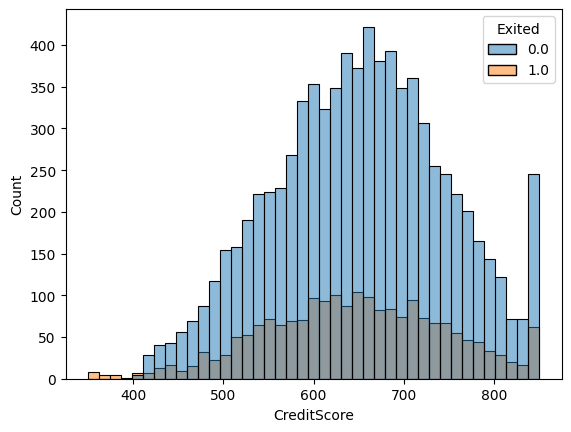

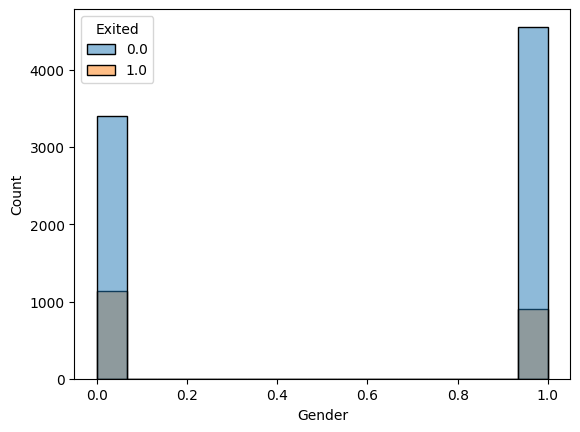

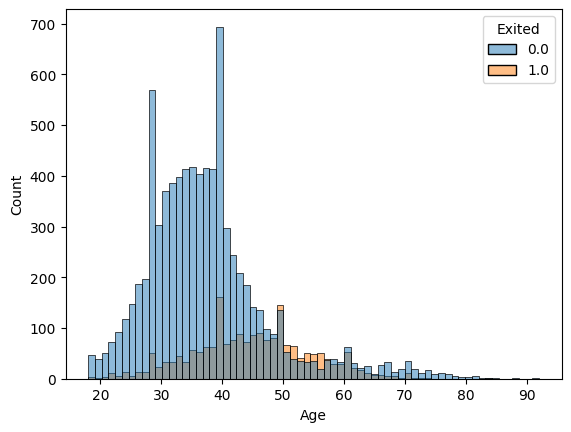

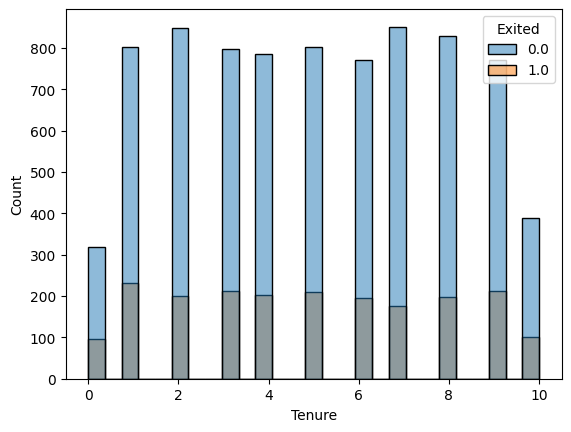

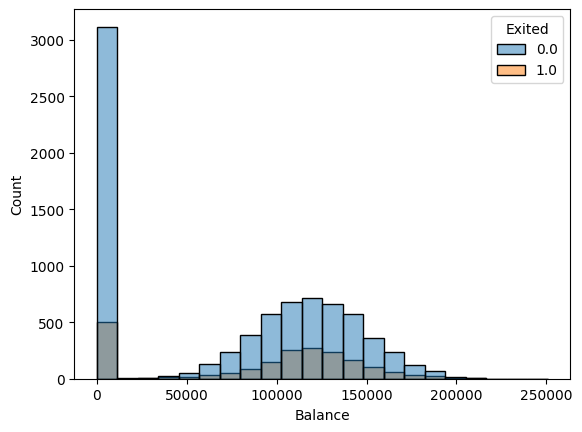

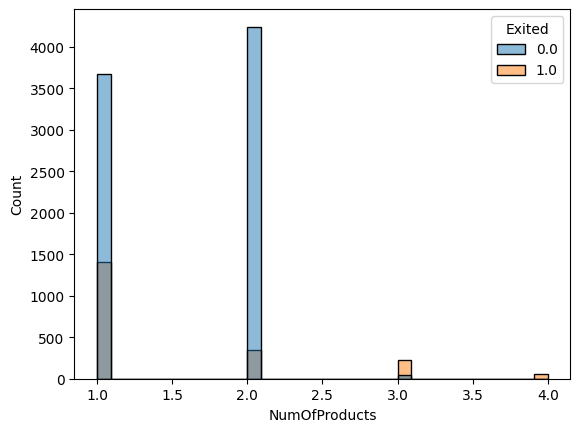

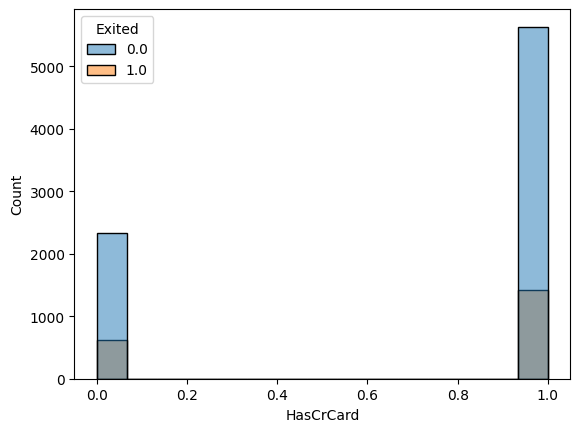

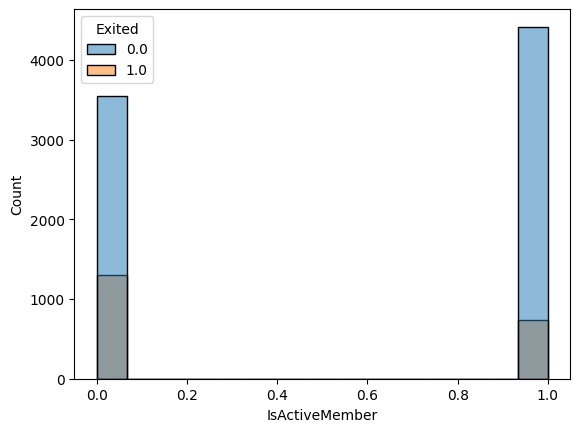

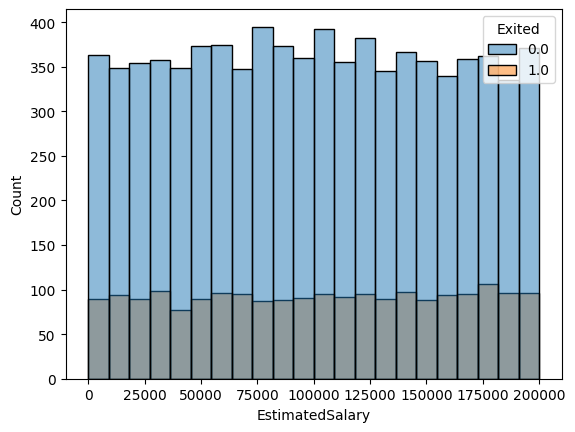

,1
CreditScore,0.0067
Gender,0.0000
Age,0.0000
Tenure,0.1615
Balance,0.0000
NumOfProducts,0.0000
HasCrCard,0.4754
IsActiveMember,0.0000
EstimatedSalary,0.2264
France,0.0000


значимые признаки 

 Index(['CreditScore', 'Gender', 'Age', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'France', 'Germany', 'Spain'],
      dtype='object')


In [156]:
sig=dict()
for col in churn_df.drop(['Exited', 'Geography'],  axis=1).columns:
  sig[col]=ttest_ind(churn_df.query('Exited==1')[col], churn_df.query('Exited==0')[col])
  if col not in ['France', 'Germany', 'Spain']:
    sns.histplot(data=churn_df, x=churn_df[col], hue='Exited')
    plt.show()
sign=pd.DataFrame(sig).T.round(4)[1]
display(sign)
print('значимые признаки', "\n\n", sign[sign<=0.05].index)


Дополнительно проеряем на категориальные данные на chi2 и получаем аналогичные резуьтаты.

In [157]:
from scipy.stats import chi2_contingency

cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
for col in cat_cols:
    contingency = pd.crosstab(churn_df[col], churn_df['Exited'])
    stat, p, _, _ = chi2_contingency(contingency)
    print(f'{col}: chi2={stat:.3f}, p={p:.5f}')


Geography: chi2=301.255, p=0.00000
Gender: chi2=112.919, p=0.00000
HasCrCard: chi2=0.471, p=0.49237
IsActiveMember: chi2=242.985, p=0.00000


In [158]:
list(sign[sign.ge(0.05)].index)

['Tenure', 'HasCrCard', 'EstimatedSalary']

Как мы видим, статистически значимые различия у нас присутствуют для всех оставшихся признаков кроме 'Tenure', 'HasCrCard', 'EstimatedSalary' ('Клиентский стаж', 'Наличе карт', 'оценка должностного оклада').

Поскольку мы планируем применение бустинговых методов, отличающихся устойчивостью к отклонению от нормального распределени и выбросам, преобразовывать данные мы не будем. Однако, при необходимости использования классических линейных алгоритмов, нам потреюуется


Теперь посмотрим как влияют

<Axes: xlabel='Tenure'>

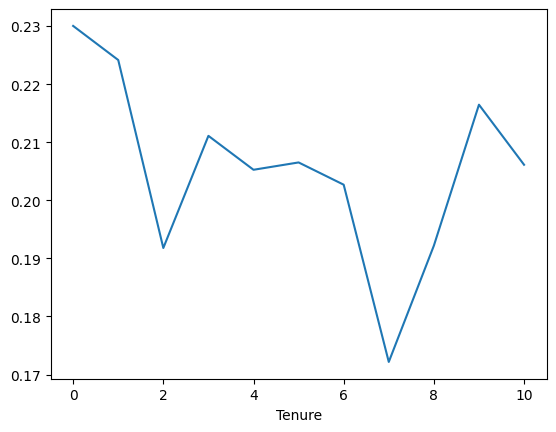

In [159]:
churn_df.groupby(['Tenure']).Exited.mean().plot()

Как мы видим, самые низкие оттоки наблюдаются на втором и 7 году клиетского стажа,три самых высоких значения оттокна 9 году стажэа. Очевидно, что на второй и на 7 год стоит планировать мероприятия по увеличению лояльности.

Отличается ли поведение мужчин и женщин?

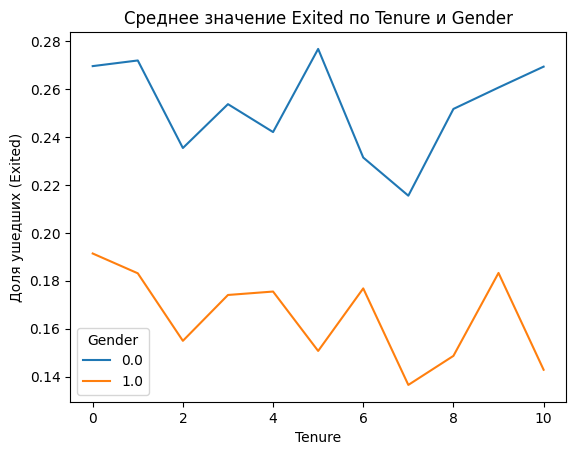

In [160]:
grouped = churn_df.groupby(['Tenure', 'Gender'],
                           as_index=False)['Exited'].mean()

sns.lineplot(data=grouped, x='Tenure', y='Exited', hue='Gender')
plt.title('Среднее значение Exited по Tenure и Gender')
plt.ylabel('Доля ушедших (Exited)')
plt.show()

Как мы видим, колебания оттока со стажем, у мужчин и женщин протекают в непересекающихся корридорах значений. Женщино более склонны к закрытию счёта в банке, и пик оттока у них приходится на 5 лет (что интересно у мужчин это стаж локального минимума оттока). Также интересно то, что у мучжин на 10 год отток снижается в то время как у женщин он продолжает расти и достигает одного из трёх самых высоких значений (возможно локального максимума). Девятый год характиризуется повышенным оттокам у обоих групп.

Теперь посмотрим как на поведение во времени влияет страна.

Мы наблюдаем интересное явление: у испанцев отток со стажем снижается, у французов усойчиво растёт после 7 года, а у немцев несмотря на широкийй размах колебаний в целом стабилен. Самый высокий отток наблюдается в Германии на второй год, а самый низкий, в Испании на 10 год.

Таким образом напрашиваются следующие меры:

1) Очень важно повышать лояльность у немцев в первый год их стажа (их в первый год уходит так много, что в следующем году образуется провал, который восстанавливается к третьему году. Серьёзных мер воздействия на их поведение похоже нет.

2) Испанцы быстро привыкают к банку чем больше стаж, тем менее они склонны к оттоку. Им вполне можно предлагать долгосрочные и сложные продукты и максимизировать продажи

3) А вот французы чей стаж в банке превышает 7 лет, начигнают интенсивнее покидать банк, следовательно для французовс этим стажем стоит разрабатывать программу повышения лояльности.

А как обстоит дело с рассмотрением дополнительного разреза половой принадлежности?

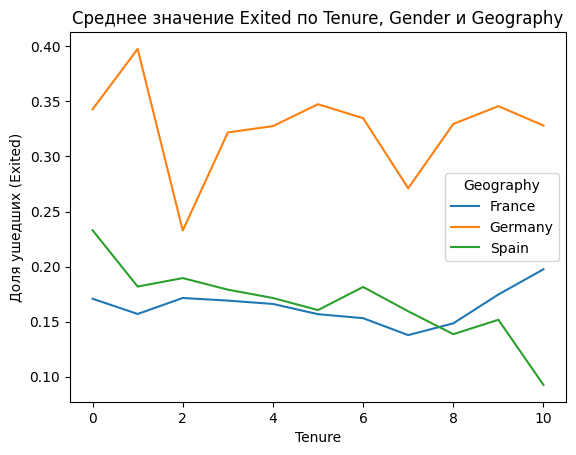

In [161]:
grouped = churn_df.groupby(['Tenure', 'Geography'], as_index=False)['Exited'].mean()

sns.lineplot(data=grouped, x='Tenure', y='Exited', hue='Geography')
plt.title('Среднее значение Exited по Tenure, Gender и Geography')
plt.ylabel('Доля ушедших (Exited)')
plt.show()

In [162]:
 churn_df.groupby(['Tenure', 'Geography']).Exited.mean().unstack().agg(['min','mean', 'median', 'max', 'std', 'argmin', 'argmax'])

Geography,France,Germany,Spain
min,0.137681,0.232727,0.092437
mean,0.163828,0.325412,0.167147
median,0.166016,0.329545,0.171429
max,0.197531,0.397727,0.233010
std,0.015893,0.042548,0.034876
argmin,7.000000,2.000000,10.000000
argmax,10.000000,1.000000,0.000000


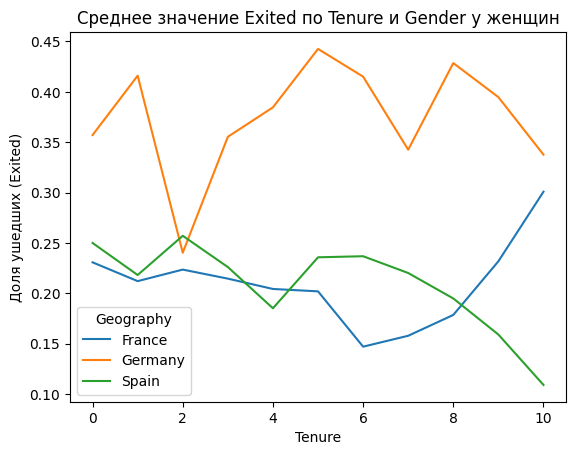

In [163]:
grouped = churn_df.query('Gender==0').groupby(['Tenure', 'Geography'], as_index=False)['Exited'].mean()

sns.lineplot(data=grouped, x='Tenure', y='Exited', hue='Geography')
plt.title('Среднее значение Exited по Tenure и Gender у женщин')
plt.ylabel('Доля ушедших (Exited)')
plt.show()

У немецких женщин тренд как таковой отсутствует, а вот у испанок и францеженок переломным оказывается 6 год. Именно с него растёт отток у француженок (доля ушедшив возрастает в 2 раза!) и начинает устойчиво снижаться отток у испанок (в 2,5 раза).

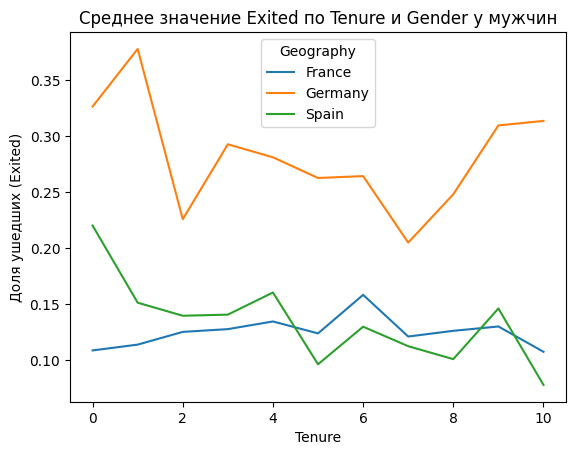

In [164]:
grouped = churn_df.query('Gender==1').groupby(['Tenure', 'Geography'], as_index=False)['Exited'].mean()

sns.lineplot(data=grouped, x='Tenure', y='Exited', hue='Geography')
plt.title('Среднее значение Exited по Tenure и Gender у мужчин')
plt.ylabel('Доля ушедших (Exited)')
plt.show()

У мужчин тренд на снижение имеется только у испанцев, у французов и немцев тренд практически отсутствует.

Таким образом напрашиваются следующие меры:

1) Очень важно повышать лояльность у немцев в первый год их стажа (их в первый год уходит так много, что в следующем году образуется провал, который восстанавливается к третьему году. Серьёзных мер воздействия на их поведение похоже нет.

2) Испанцы быстро привыкают к банку чем больше стаж, тем менее они склонны к оттоку. Им вполне можно предлагать долгосрочные и сложные продукты и максимизировать продажи

3) Француженки чей стаж в банке превышает 7 лет, начинают интенсивнее покидать банк, следовательно для французовс этим стажем стоит разрабатывать программу повышения лояльности. Она может включать в себя

In [165]:
churn_df.drop('Geography', axis=1).query(('Gender==0.0 and Tenure>=6')).groupby('Exited').mean().iloc[:,:-3]

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,,
0.0,649.267799,0.0,37.376878,7.740039,69611.508609,1.547355,0.706728,0.543436,98917.507342
1.0,647.097760,0.0,44.317719,7.857434,91712.291527,1.492872,0.708758,0.364562,107891.976456


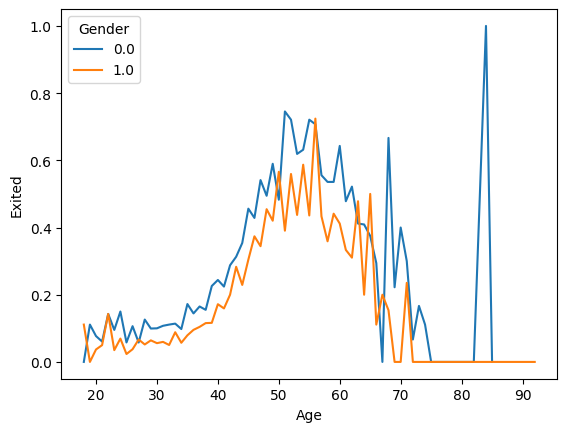

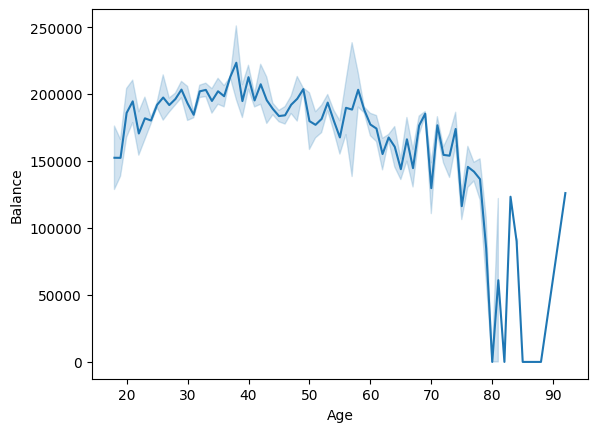

In [166]:
grouped = churn_df.groupby(['Age', 'Gender'], as_index=False).agg({'Exited':'mean', "Balance":'max'})
sns.lineplot(data=grouped, x='Age', y='Exited', hue='Gender')
plt.show()
sns.lineplot(data=grouped, x='Age', y='Balance')
plt.show()
# sns.lineplot(data=grouped, x='Age', y='Exited', hue='Gender')
# plt.title('Среднее значение Exited по Tenure и Gender')
# plt.ylabel('Доля ушедших (Exited)')
# plt.show()

Женщины любого возраста отличаются более высокой мклонностью к оттоку чем мужчины. До 60 лет наблюдается небольшой медианного баланса счёта, но далее ряд становится резко гетероскедастичным (ввиду значительно меньшего количества наблюдений для данной возрастной группы).


### 1. Количественное соотношение клиентов

Наш анализ признаков мы начнём с оценки оттока клиентов из банка

In [167]:
churn=churn_df['Exited'].value_counts(normalize=True)*100


Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов')

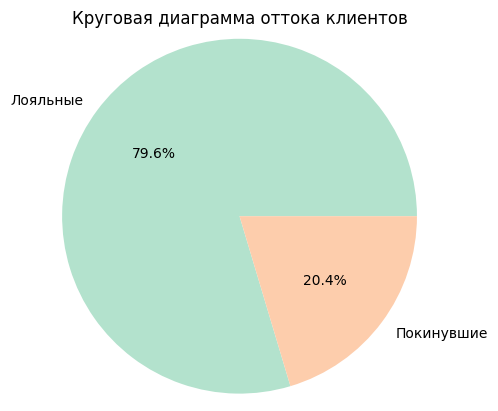

In [168]:
plt.pie(churn, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов")

Итак, банк покинул каждый пятый клиент. Оценим распределения суммарного объём средств на счетах.

Text(0.5, 1.0, 'Круговая диаграмма суммарного баланса счетов')

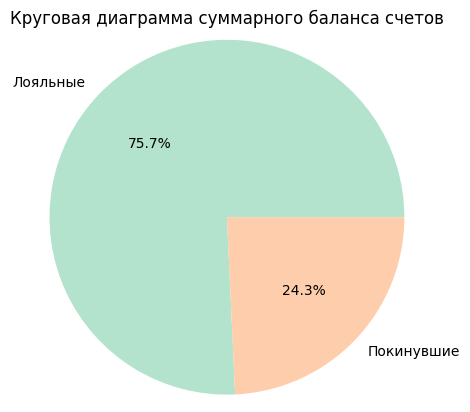

In [169]:
churnbal=churn_df.groupby('Exited').Balance.sum()
plt.pie(churnbal, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма суммарного баланса счетов")

На покинувших банк клиентов приходится каждое четвёртое евро на счетах. Мы будем использовать это значение в качестве базовой линии при оценке оттока отмечаемого для определённых значениях баланса. Далее мы рассмотрим признаки которые оказывают влияние на отток клиентов и изучим их взаимосвязь.

### 6. Половой состав клиентов банка

Выясним сколько среди клиентов банка мужчин и сколько женщин

,count
Gender,
1.0,5457
0.0,4543


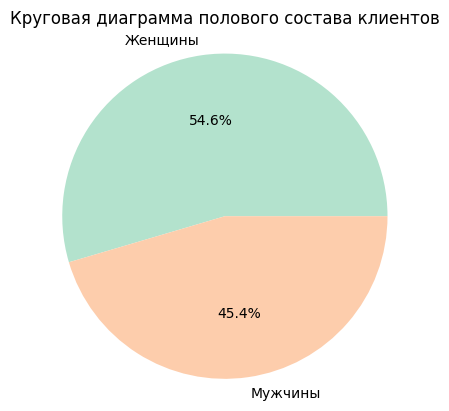

In [170]:
gender=churn_df.Gender.value_counts()
plt.pie(gender, labels=['Женщины', 'Мужчины'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.1)
plt.title("Круговая диаграмма полового состава клиентов")
gender

А теперь посмотрим, изменяется ли соотношение клиентов мужского и женского пола среди нелояльных клиентов?

,count
Gender,
0.0,1139
1.0,898


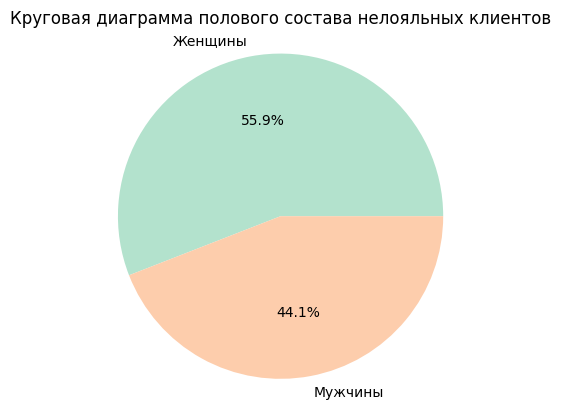

In [171]:
churngender=churn_df[churn_df.Exited==1].Gender.value_counts()
plt.pie(churngender, labels=['Женщины', 'Мужчины'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.1)
plt.title("Круговая диаграмма полового состава нелояльных клиентов")
churngender

Цифры практически идентичны и пол не является признаком позволяющим дифференцировать потенциально нелояльных клиентов.

### 2. График распределения баланса пользователей в разрезе лояльности

Для определения характера распределения сумм на счетах клиентов, построим гистограмму в разрезе решений клиента
по сотрудничеству с банком.

In [172]:
churn_df[churn_df['Balance']==0].shape[0]

3617

Для 3617 клиентских счетов мы имеем нулевой баланс, что составляет 36% счетов банка.

**<span style="color:crimson;"> ВАЖНО!: </span>**
    
<span style="color:crimson;">Поскольку по счетам с нулевым балансому нас отсутствует информация, позволяющая понять причину по которой на этих счетах нет денежных средств (счёт обнулён и неиспользуется ; средства выведены на другой счёт этого клиента в банке ; клиент получает зарплату и сразу же снимает все деньги; клиент открыл счёт но ещё не внёс на него денежные средства, прочие возможные причины). Поэтому формально мы не имеем права исключать эти позиции из рассмотрения как неинформативные (возможно клиент открыл счёт и ждёт многомилионное наследство :) ), однако при рассчёте средних значений мы в дальнейшем будем учитывать только ненулевые балансы.  </span>

Посмотрим, сколько среди клиентов с нулевым счётом покинувших банк.

Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов с нулевым балансом')

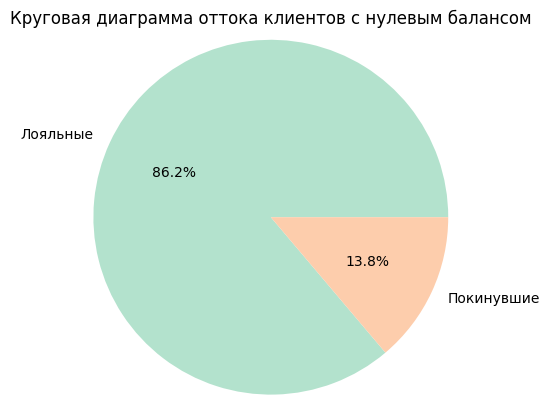

In [173]:
zchurn_bal=churn_df[churn_df.Balance==0]['Exited'].value_counts(normalize=True)*100
plt.pie(zchurn_bal,
        labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов с нулевым балансом")

Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов с нулевым балансом')

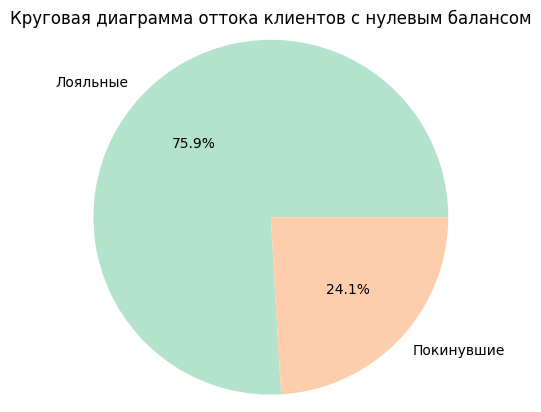

In [174]:
zchurn_bal=churn_df[churn_df.Balance!=0]['Exited'].value_counts(normalize=True)*100
plt.pie(zchurn_bal,
        labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов с нулевым балансом")

Создаём бинарный признак нулевого баланса churn_df['Zero_Balance']

In [175]:
churn_df['Zero_Balance']=(churn_df['Balance']==0).astype(float)

Таким образом, среди владельцев счетов с нулевым балансом, доля покинувших банк меньше чем в целом по счетам. Возможно мы имеем молчаливый отток клиентов либо лояльные клиенты с нулевым балансом по каким-то причинам держатся за этот банк.  Соответственно для ненулевых счетов у нас получается следующая картина:

Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов с ненулевым балансом')

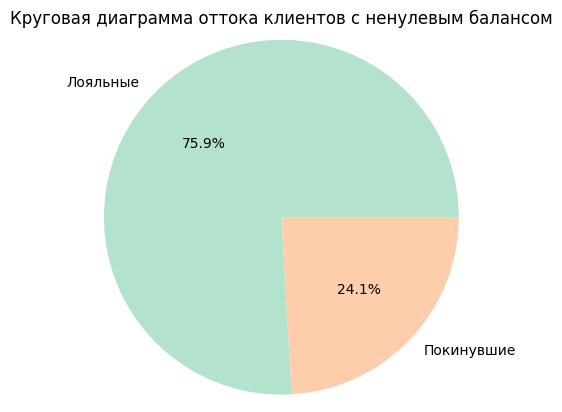

In [176]:
nzchurn_bal=churn_df[churn_df.Balance>0]['Exited'].value_counts(normalize=True)*100
plt.pie(nzchurn_bal,
        labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов с ненулевым балансом")

Преобразуем переменнную логарифмированием

In [177]:
# Шаг 1: Логарифмическое преобразование
churn_df['Balance_log'] = np.log(churn_df['Balance'] + 1)

Для удобства построения гистограммы зададимся нижней границей баланса равной 2500 Евро. Перерисуем основную гистограмму в разрезе лояльности.

Мы видим, что оба распределения являются нормальными и имеют очень близкие модальные значения.
Исходя из гистограммы, распределение балансов у покинувших банк и оставшихся в нём клиентов одинаковое, но у распределения нелояльных клиентов более тяжёлый правых хвост. Посмотрим rкакую долю в суммарном распределении балансов составляют распределения лояльных и нелояльных клиентов.

Text(0.5, 1.0, 'Распределение баланса в разрезе лояльности')

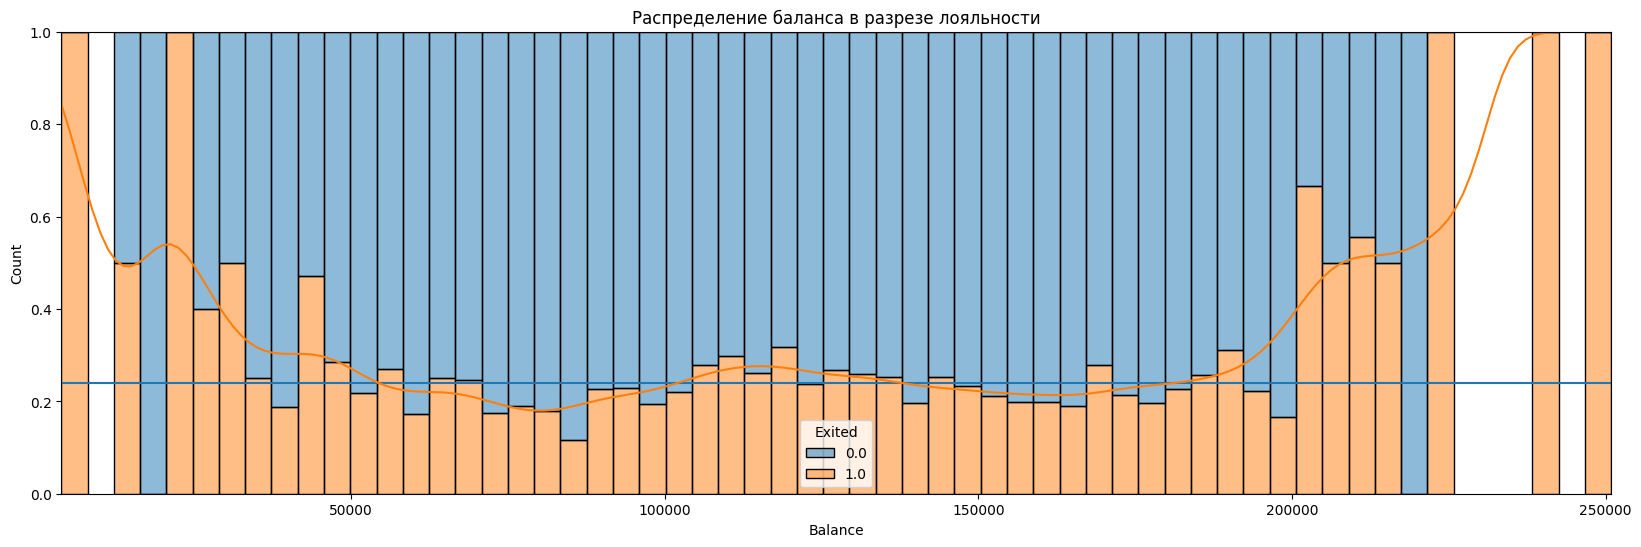

In [178]:
nzchurn=churn_df[churn_df['Balance']>0]
plt.figure(figsize=(20, 6))
plt.axhline(0.24)
sns.histplot(x=nzchurn['Balance'],
             hue=churn_df['Exited'], multiple='fill', element='bars',
             kde=True, )
plt.title("Распределение баланса в разрезе лояльности")

Итак мы видим что в диапазоне до 50 тыс. евро и после 170 тыс. евро у нас иммет место повышенный отток клиентов. Посмотрим суммарные балансы этих подгрупп.


In [179]:
below50=churn_df.query('0<Balance<50000')

In [180]:
print("суммарный баланс счетов до 50000 Евро:", round(below50.Balance.sum()), 'Евро')

суммарный баланс счетов до 50000 Евро: 2958565 Евро


In [181]:
above200=churn_df[churn_df['Balance']>200000]

In [182]:
print("суммарный баланс счетов свыше 200000 Евро:", round(above200.Balance.sum()))

суммарный баланс счетов свыше 200000 Евро: 7147131


Оценим оттоки для этих групп

In [183]:
float(round(below50.Exited.mean(),2))

0.35

In [184]:
float(round(above200.Exited.mean(), 2))

0.56

Оценим вклад этой группы клиентов в суммарный баланс банка.

In [185]:
float(((below50.Balance.sum()+above200.Balance.sum())*100/churn_df.Balance.sum()).round(3))

1.321

Итак вклад этой группы клиентов составляет 1,3% от всех средств на счетах клиентов банка.  Если программа повышения лояльности  для этой группы окупится,
то целесообразно в первую очередь обратить внимание на клиентов с балансом счёта 200 000, похоже их что-то не устраивает,
либо банки-конкуренты предлагают условия повыгоднее. Также можно разработать программу лояльности для клиентов с балансами до 50000 Евро.

## 4.  Влияние возраста на отток клиента

Рассмотрим как изменяется возраст клиентов в разрезе их лояльности.

Text(0.5, 1.0, 'Возраст клиентов в разрезе лояльности')

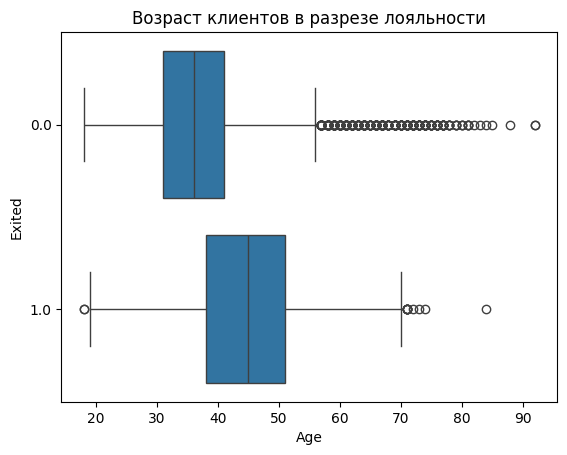

In [186]:
sns.boxplot(x=churn_df['Age'], y=churn_df["Exited"], orient="h") #
plt.title("Возраст клиентов в разрезе лояльности")

Как мы видим:
1) Основное количество наблюдений для лояльных клиентов находится в диапазоне 20-55 лет. Имеется заметное количество выбросов, но соответствующие им наблюдения не следует исключать из рассмотрения. В целом распределение нормальное хотя и  правым тяжёлым хвостом. Меданное значение у лояльных клиентов находится в районе 35 лет.
2) Для нелояльных клиентов диапазон значений шире, он охватывает возраст от 20 до 70 лет. Количество выбросов незначительное. Медианное значение у нелояльных смещено вправо и составляет 45 лет.
3) Таким образом, нелояльный клиент медианно старше лояльного на 10 лет. А клиенты старше 55 лет представляют собой "группу риска". Возможно у нелояльной их части, по мере приближения к пенсионному возрасту обостряется желание выбрать банк получше.

Выясним, каков процент клиентов покинувших банк в возрастной группе 55+

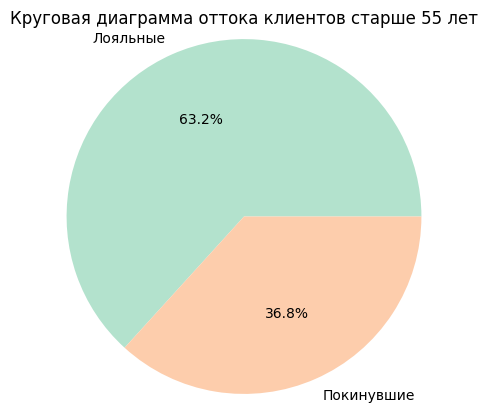

In [187]:
churn_df55=churn_df[churn_df['Age']>55] #Отток клиентов старшее 55 лет
churn55=churn_df55.groupby('Exited').Exited.count()
plt.pie(churn55, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов старше 55 лет")
plt.show()

Из этой диаграммы видно, что банк покидает каждый третий клиент в возрасте от 55 лет.
Следовательно необходима разработка мер по повышению лояльности клиентов этой возрастной группы.
Посмотрим, одинаково ли поведение мужчин и женщин этого возраста.


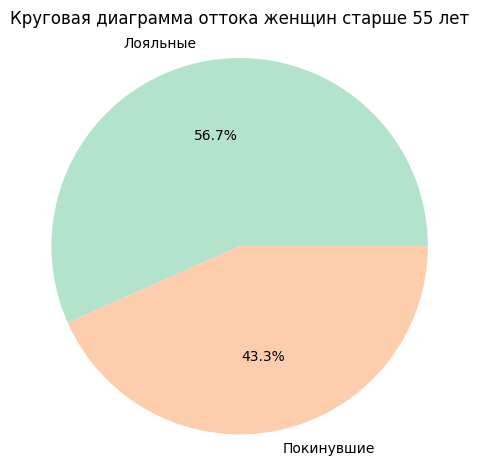

In [188]:
churn_df55f=churn_df.query('Age>55 & Gender==0.0') # Женщины старше 55
churn55f=churn_df55f.groupby('Exited').Exited.count()# Отток женщин старше 55
plt.pie(churn55f, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.1)
plt.title("Круговая диаграмма оттока женщин старше 55 лет")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Круговая диаграмма оттока мужчин старше 55 лет')

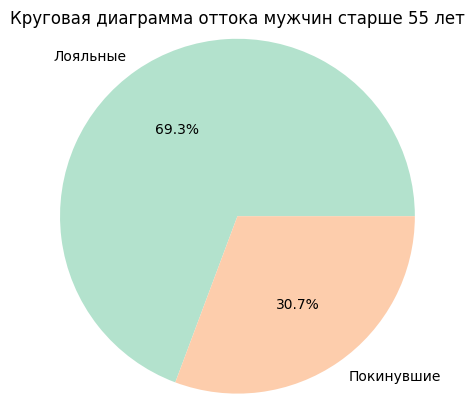

In [189]:
churn_df55m=churn_df.query('Age>55 & Gender==1.0') # Женщины старше 55
churn55m=churn_df55m.groupby('Exited').Exited.count()# Отток женщин старше 55
plt.pie(churn55m, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока мужчин старше 55 лет")

Итак, женщины старше 55 лет демонстрируют большую нелояльность банку чем мужчины и требуют особого внимания. Мы можем посмотреть каков суммарный баланс счетов клиентов.

In [190]:
m55bal=churn_df55m.Balance.sum() #Баланс счетов мужчин за 55

In [191]:
f55bal=churn_df55f.Balance.sum() #Баланс счетов женщин за 55


In [192]:
churn_female_balance=churn_df55f.groupby("Exited")['Balance'].sum() #Распределение балансов женщин за 55 по лояльности

In [193]:
churn_male_balance=churn_df55m.groupby("Exited")['Balance'].sum() #Распределение балансов мужчин за 55 по лояльности

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности')

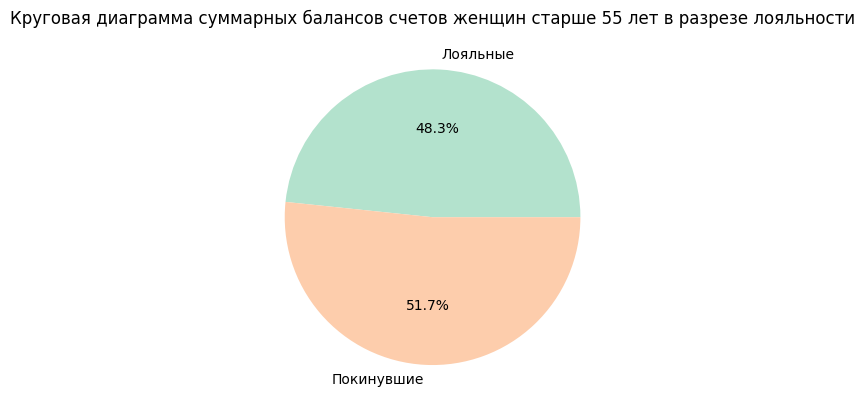

In [194]:
plt.pie(churn_female_balance, labels=['Лояльные', 'Покинувшие'], colors=sns.color_palette('Pastel2'), autopct='%.1f%%', radius=1)
plt.title("Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности")

Клиенты-женщины этой возрастной группы на момент ухода из банка, имели на счетах чуть более половины средств находящихся у клиентов в этом половозрастном разрезе. А как обстоит дело в случае мужчин за 55?

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности')

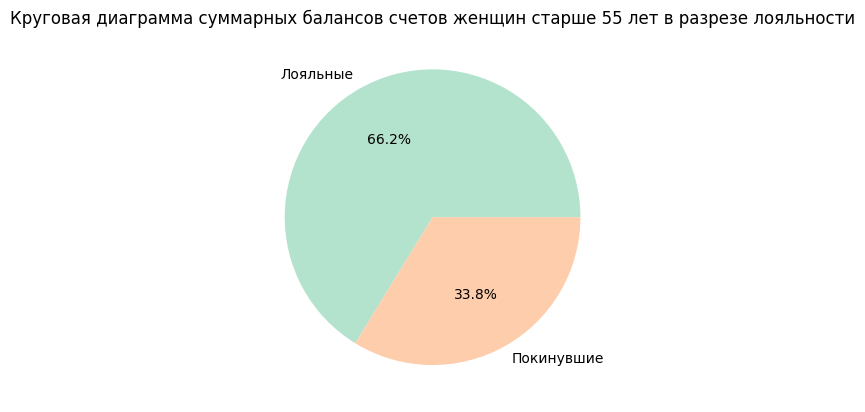

In [195]:
plt.pie(churn_male_balance, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%', radius=1)
plt.title("Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности")

Доля суммы балансов счетов для нелояльных банку мужчин за 55 составляет треть от общего суммарного баланса мужчин этого возраста.
Наконец посмотрим какую долю от суммарного баланса счетов банка составляет суммарный баланс нелояльных клиентов старше 55 лет. Далее рассмотрим это распределение для мужчин и женщин.

In [196]:
churn_age_exit_balance=churn_df.groupby(['Exited', churn_df['Age']>55]).Balance.sum()

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов в разрезе возраста (до и после 55) и лояльности')

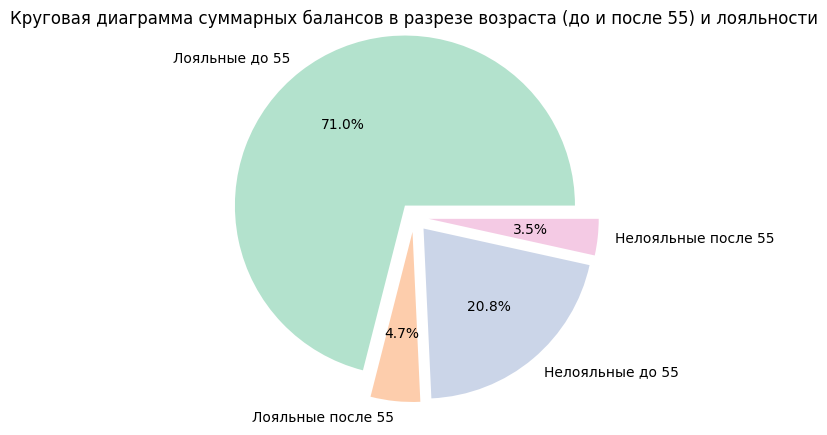

In [197]:
plt.pie(churn_age_exit_balance,
        labels=['Лояльные до 55', 'Лояльные после 55', 'Нелояльные до 55', 'Нелояльные после 55'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        explode = (0.1, 0.1, 0.1, 0.1),
        radius=1.15)
plt.title("Круговая диаграмма суммарных балансов в разрезе возраста (до и после 55) и лояльности")

Доля средств нелояльных клиентов за 55, составляет 3,5% от полной суммы балансов клиентов и 17% от общей суммы средств нелояльных клиентов, в то время как доля  лояльных клиентов этой возрастной группы среди всех лояльных клиентов всего 6,6%.
Суммарные объёмы денежных средств у лояльных и нелояльных клиентов старше 55 лет в целом примерно одного порядка
и видимо отражают возрастную струкуру вкладов.

Нелояльные женщины старшее 55 имеют на своём балансе почти 5% средств банка. Банку следует выяснить причину нелояльности
этой клиентской группы и внести необходимые коррективы.

Исходя из вышесказанного, банку следует фокусироваться на потенциально нелояльных клиентах старше 55 лет и разработать для них программы повышения лояльностим с основным упором на клиентов женского пола.

### 5. Взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты

Выясним имеется ли связь между кредитным рейтингом клиентов и их зарплатами. Для этого построим парный график показывающий характер зависимости между предикторами и характер их распределений.

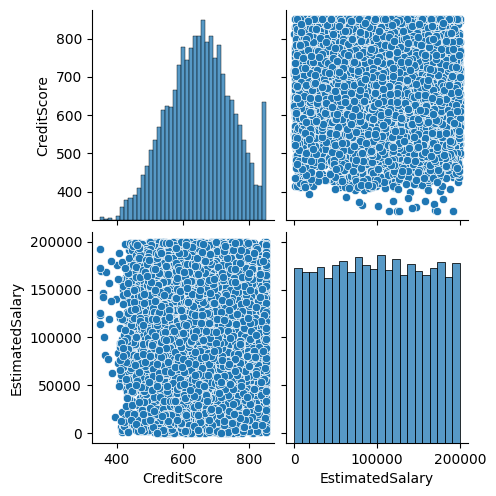

In [198]:
sns.pairplot(churn_df[['CreditScore','EstimatedSalary']])

Как мы видим, распределение оценок заработных плат близко к прямоугольному
а распределение кредитных рейтингов близко к нормальному, но справа отмечается вторая мода распределения. Определим моды. Зависимость между признаками отсутствует. Посмотрим как ведут себя признаки в разрезе лояльности

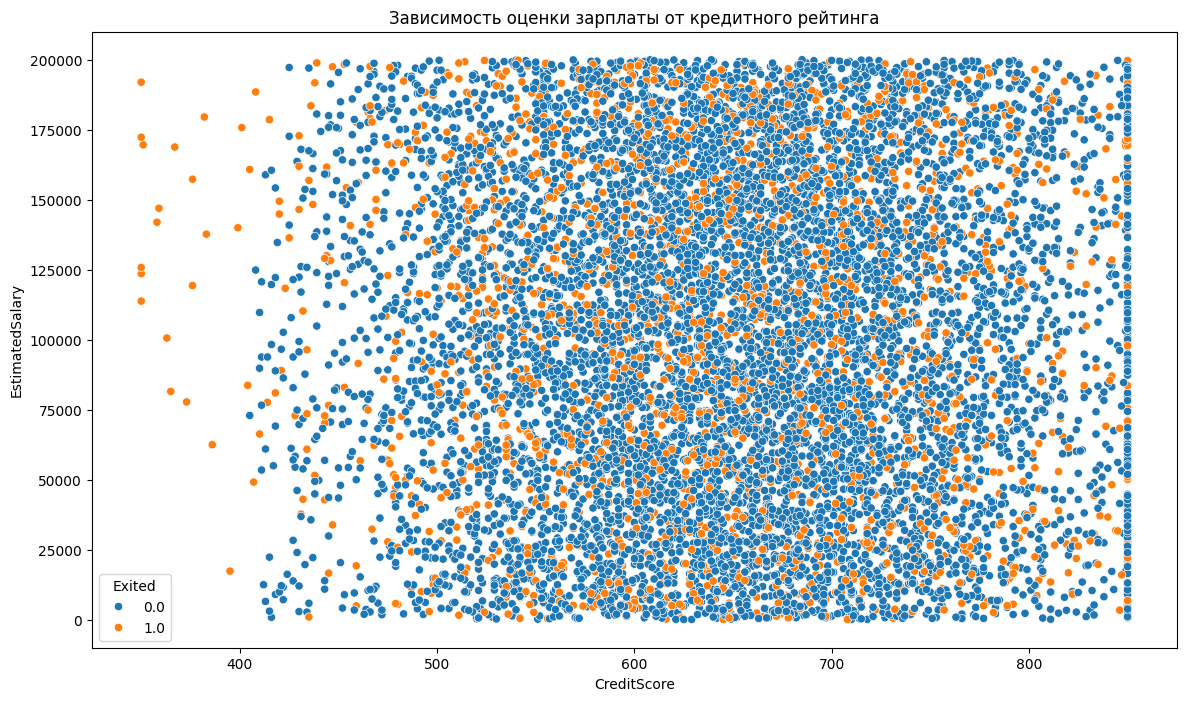

In [199]:
fig=plt.figure(figsize=[14, 8])
sns.scatterplot(x=churn_df['CreditScore'],
                y=churn_df['EstimatedSalary'],
                hue= churn_df['Exited']).set_title("Зависимость оценки зарплаты от кредитного рейтинга")
plt.show()

In [200]:
churn_df['Low_score']=churn_df['CreditScore']<=400

Мы отчётливо видим на графике, что в зоне кредитного рейтинга до 400 единиц, присутствуют только нелояльные клиенты с различными уровнями зарплат. Интересно отметить, что для этой группы клиентов имеется слабая отрицательная зависимость между зарплатами и кредитным рейтингом. Возможным объяснением является меньшее внимание уделяемое высокооплачивыми клиентами своей кредитной репутации. Учитывая низкий скоринг, банку следует подумать, целесообразно ли вовлечение подобных им клиентов в программы лояльности, или их уход в интересах банка.

Text(0.5, 1.0, 'Низкорейтинговые нелояльные клиенты')

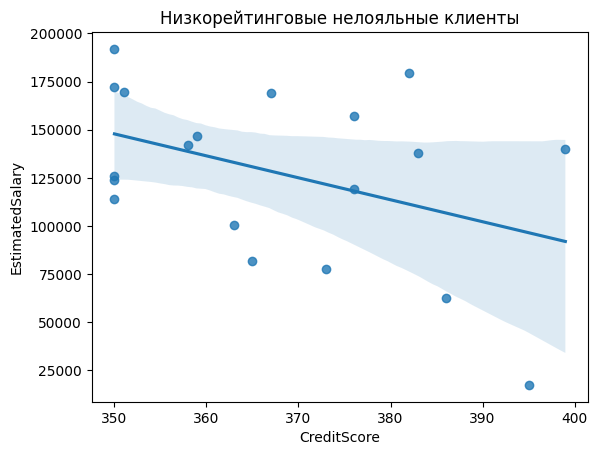

In [201]:
sns.regplot(x=churn_df[churn_df['CreditScore']<400]['CreditScore'],
            y=churn_df[churn_df['CreditScore']<400]['EstimatedSalary'],
            data=churn_df).set_title("Низкорейтинговые нелояльные клиенты")

Сравним медианные значения ненулевых балансов для всей совокупности ненулевых счетов и для счетов клиентов с кредитными рейтингами <400.

In [202]:
churn_df[churn_df['CreditScore']<400][churn_df['Balance']>0]['Balance'].median()

127707.645

In [203]:
churn_df['Balance'][churn_df['Balance']>0].median()

119839.69

Баланс счёта у низкорейтинговых клиентов медианно выше медианного значения по всей совокупности. Таким образом рейтинг для этой группы скорее всего отражает не финансовое положение клиента, а его отношение к банку.

Таким образом, у нас появляется ещё один диагоностический признак потенциально нелояльного клиента: кредитный рейтинг менее 400 единиц.

### 7. Зависимость оттока клиентов  от количества приобретённых у банка услуг.

Проверим, связано ли количество услуг оказываемых банком клиентам с их лояльностью.
Для определения характера зависимости построим многоуровневую столбчатую диаграмму.

In [204]:
services_churn=churn_df.groupby('Exited').NumOfProducts.value_counts().unstack()
services_churn

NumOfProducts,1.0,2.0,3.0,4.0
Exited,,,,
0.0,3675.0,4242.0,46.0,NaN
1.0,1409.0,348.0,220.0,60.0


In [205]:
mapping={services_churn.index[0]:"Лояльные", services_churn.index[1]: "Нелояльные"}
services_churn=services_churn.rename(index=mapping)

Text(0, 0.5, 'Количество клиентов')

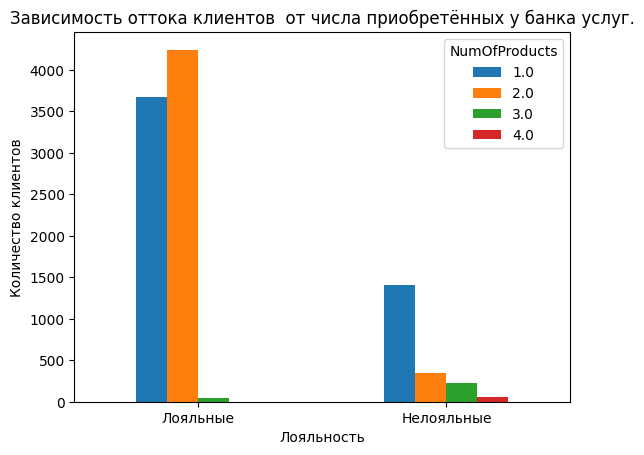

In [206]:
service_churn_bars=services_churn.plot(kind='bar', xlabel="Лояльность" )
plt.xticks(rotation = 0)

service_churn_bars.set_title('Зависимость оттока клиентов  от числа приобретённых у банка услуг.')
service_churn_bars.set_ylabel('Количество клиентов')

Лояльные клиенты в большинстве случаев предпочитают иметь один или два продукта, три услуги приобретаются очень редко,
а четырьмя услугами не пользуется ни один из клиентов сохранивших лояльность. Посмотрим каково распределение встречаемости трёх услуг в разрезе лояльности

In [60]:
triple_service_loyality=services_churn.loc["Лояльные",3]*100/(services_churn.loc["Лояльные",3]+services_churn.loc["Нелояльные",3])
print(str(round(triple_service_loyality, 1))+'%')

17.3%


То есть тремя услугами воспользовались и остались в банке только 17% клиентов от всех воспользовавшихся тремя услугами. Таким образом, в группу риска входят клиенты имеющие более двух продуктов. Для моделирования имеет смысл использовать бинарную переменную наличия/отсутствия 3-х или 4-х услуг.

Непонятно, предлагались ли эти услуги банком, или клиент самостоятельно их выбрал. Если клиент не имел необходимости в этих услугах и их предложил банк, возможно именно большое количество услуг вызвало нелояльность (к примеру стоимость обслуживания оказались выше чем ожидал клиент, либо предлагались услуги недостаточно проработанные с точки зрения подддержки).

Однако, возможна ситуация когда клиент действительно нуждался в помощи и именно поэтому ему были предложены какие-то дополнительные услуги, которые ему не помогли, а только усугубили ситуацию.

В любом случае, не рекомендуется предлагать клиенту более 2-х услуг.

### 8. Связь активности клиента с его лояльностью.

Интуитивно мы склонны предполагать что активные клиенты довольны своим сотрудничеством с банком и не стремятся его покинуть. Проверим, так ли это?

In [61]:
activity_churn=churn_df.groupby(['IsActiveMember', 'Exited']).Exited.count().unstack()

Text(0.5, 1.0, 'Тепловая диаграмма активность-отток')

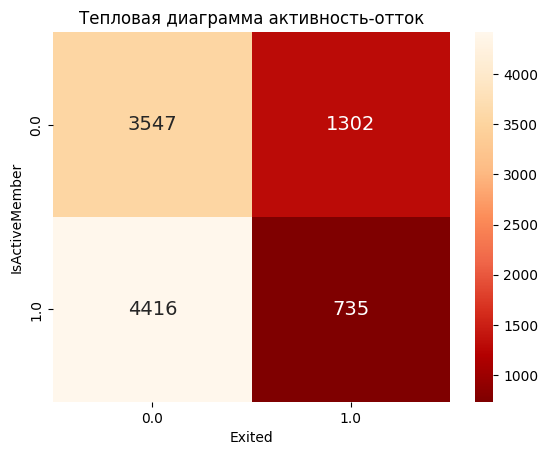

In [62]:
sns.heatmap(activity_churn,
            cmap='OrRd_r',
            annot=True,
            annot_kws={"size": 14},
            fmt="1"
           ).set_title("Тепловая диаграмма активность-отток")

Из тепловой диаграммы следует что активные клиенты значительно лояльнее неактивных. Использование данного признака поможет оценить лояльность клиентов, и при необходимости запустить программу лояльности для неактивных клиентов.

### 10. Зависимость лояльности от категоризированного кредитного рейтинга и клиентского стажа

Проведём категоризацию кредитного рейтинга:
    
* "Deep" для credit_score < 300:
* "Very_Poor" для credit_score >= 300 и credit_score < 500:
* "Poor" для credit_score >= 500 и credit_score < 601:
* "Fair" для redit_score >= 601 и credit_score < 661
* "Good" для credit_score >= 661 и credit_score < 781
* "Excellent" для credit_score >= 781 и credit_score < 851:
* "Top" для credit_score >= 851

Построим сводную таблицу категоризированный рейтинг-клиентский стаж для двух выборок:
    1) Для полной выборки.
    2) Для выборки с ненулевыми балансами.

In [63]:
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return 1
    elif credit_score >= 500 and credit_score < 601:
        return 2
    elif credit_score >= 601 and credit_score < 661:
        return 3
    elif credit_score >= 661 and credit_score < 781:
        return 4
    elif credit_score >= 781 and credit_score < 851:
        return 5
    elif credit_score >= 851:
        return 6
    elif credit_score < 300:
        return 7


Tenure,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
credit_score_cat,,,,,,,,,,,
1,44.44,25.37,15.15,28.57,29.31,14.93,22.54,20.63,25.35,22.95,33.33
2,22.64,25.94,21.18,21.22,23.32,19.92,17.99,15.13,21.46,25.11,16.95
3,21.74,21.56,21.30,21.65,19.72,20.69,23.64,17.11,20.90,19.00,20.54
4,20.38,20.36,18.73,20.60,19.51,21.45,18.29,19.19,15.24,19.47,19.78
5,27.50,20.83,13.73,16.83,13.19,23.33,24.14,12.77,19.61,27.08,25.49


Text(0.5, 1.0, 'Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа')

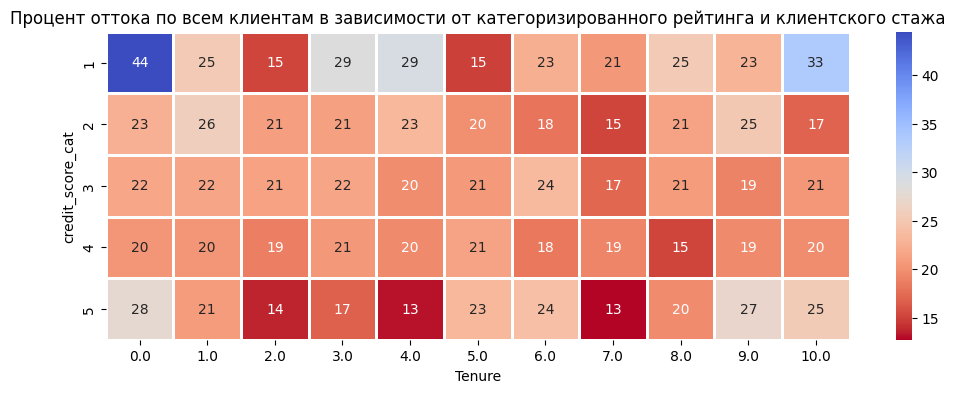

In [64]:
churn_df['credit_score_cat']=churn_df['CreditScore'].apply(get_credit_score_cat)
tenure_score_churn=churn_df.pivot_table(values='Exited',
                                        index='credit_score_cat',
                                        columns='Tenure',
                                        aggfunc='mean')*100
display(tenure_score_churn.round(2))
plt.figure(figsize=(12, 4))
sns.heatmap(tenure_score_churn, cmap='coolwarm_r', annot=True, linewidths=1).set_title("Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа")

Для полной совокупности клиентов мы видим что самый высокий отток клиентов наблюается в случае клиентоа с низким кредитным рейтингом до года.
Второй по величине отток фиксируется на 10 год сотрудничества с банком. Все остальные соотношения вроде не вызывают беспокойствия.
Но посмотрим что мы получили на ненулевой выборке клиентов банка?


Tenure,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
credit_score_cat,,,,,,,,,,,
1,46.67,26.00,17.95,29.27,36.59,16.67,20.00,25.00,31.37,30.77,35.71
2,28.21,31.10,23.46,27.39,27.27,25.71,21.68,18.31,27.56,29.14,18.42
3,24.53,24.31,23.13,27.15,22.00,21.66,28.03,19.39,26.38,24.67,22.39
4,23.36,22.52,20.00,24.07,23.01,27.82,22.71,22.22,19.82,24.11,21.67
5,34.78,22.73,11.76,17.91,16.67,29.41,31.37,16.39,23.08,35.00,31.43


Text(0.5, 1.0, 'Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа')

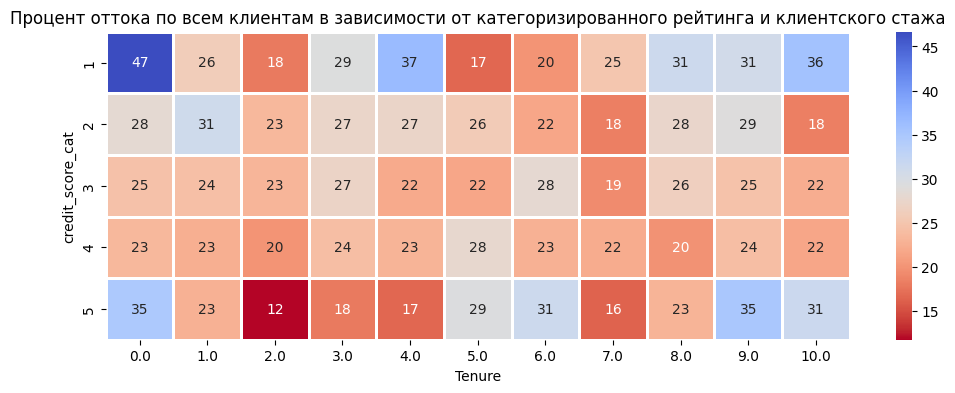

In [65]:
churn_df['credit_score_cat']=churn_df['CreditScore'].apply(get_credit_score_cat)
tenure_score_churn=churn_df[churn_df['Balance']>0].pivot_table(values='Exited', index='credit_score_cat', columns='Tenure', aggfunc='mean')*100
display(tenure_score_churn.round(2))
plt.figure(figsize=(12, 4))
sns.heatmap(tenure_score_churn, cmap='coolwarm_r', annot=True, linewidths=1).set_title("Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа")

Мы обнаруживаем что есть ещё одна проблемная категория, а именно высокорейтинговые клиенты.
С ними возникает проблема в первый год сотрудничества выливающаяся в 35% отток, далее ситуация сглаживается, но на 9-ом году случается рецидив равной магнитуды. Кроме того имеют места два всплеска магнитудой в 31% на 6 и 10 году. Поведение клиентов этой рейтинговой категории можно объяснить тем, что они знают себе цену и считают что могли бы получить от банка больше преференций. Необходимо предпринимать меры для их удержания на первом году сотрудничества,
а также обязательно ремотивировать их на 9  году. Возможно стоит провести мероприятия по повышению их лояльности через 5 лет после прихода клиента в банк,
приурочив их к пятилетнему юбилею сотрудничества.

Но как мы видим ниже и с клиентами самого низкого рейтинга всё обстоит сложнее чем мы могли бы предполагать базируясь на полном сете данных. Мы имеем для этой категории не только 47% отток в первый год, но и 2 мощных всплеска: на 10 год и не увиденный нами ранее всплеск на 4 год. Всплеску на 10 год предшествует также повышенный отток на 8 и 9 годы. Следовательно, если эта группа клиентов представляет для нас интерес, нам необходимо разработать мероприятия на 1 и 4 год сотрудничества с ними, а также программу лояльности начиная с 8-го года их пребывания в банке.

In [66]:
churn_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Zero_Balance,Balance_log,Low_score,credit_score_cat
0,619.0,France,0.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0,1.0,0.0,0.0,1.0,0.000000,False,3
1,608.0,Spain,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,0.0,0.0,1.0,0.0,11.336294,False,3
2,502.0,France,0.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,1.0,0.0,0.0,0.0,11.980813,False,2
3,699.0,France,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0,1.0,0.0,0.0,1.0,0.000000,False,4
4,850.0,Spain,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,0.0,0.0,1.0,0.0,11.740155,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,France,1.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,0.0,1.0,0.0,0.0,1.0,0.000000,False,4
9996,516.0,France,1.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0.0,1.0,0.0,0.0,0.0,10.957287,False,2
9997,709.0,France,0.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0,1.0,0.0,0.0,1.0,0.000000,False,4
9998,772.0,Germany,1.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,1.0,0.0,1.0,0.0,0.0,11.226260,False,4


Удаляем высококоррелированные признаки

In [67]:
churn_df.drop('Balance', axis=1, inplace=True)

## Выводы:

1) Среди клиентов банка преобладают женщины, характер распределения по полам не зависит от лояльности клиента

2) Повышенный отток характерен для клиентов со значением баланса менее 50 и более 170 тысяч евро. Необходимы мероприятия по повышению лояльности, особенно для второго сегмента (трёхуровневая порядковая переменная)

3) Лояльные клиенты медианно моложе нелояльных на 10 лет. Верхняя граница интервала в который попадает большинство лояльных клиентов 55 лет, лишь немногие лояльные клиенты старше этого возраста. При этом, имеется достаточно много нелояльныхх клиентов в возрасте 55-70 лет.

4) Ещё одним важны критерием риска потери клиента является его низкий кредитный рейтинг (не выше 400 ед.). В этом диапазоне показатель демонстрирует слабую отрицательную корреляцию с ожидаемой зарплатой. (бинарный признак)

5) Также фактором риска является пользование клиентом более двух услуг банка 6) Активность клиента более надёжный признак чем его неактивность, следовательно, активизация пассивных клиентов благотворно скажется на снижении оттока. Использование существующего признака "IsActiveMember"

6) Самые нелояльные клиенты банка-немцы, и на них следует обратить внимание.

7) Самая неблагополучная с точки зрения оттока категория это клиенты со стажем менее года, имеющие кредитный рейтинг между 300 и 500 единицами, а также клиенты с таким же рейтингом, но на 10 году работы с банком



    

## Вопросы которые необходимо уточнить для повышения адекватности модели:
    
1) какой отток клиентов является для банка приемлемым и не требующим повышения лояльности?

2) Каков порог суммарного баланса клиентов категории, выше которого целесообразны данные мероприятия?

3) Как правильно интерпретировать нулевой баланс, возможно имеется какая-то дополнительная информация?

4) Чем можно объяснить высокие зарплаты клиентов с низким рейтингом? На ум приходит только более высокая долговая нагрузка у клиентов с высокой зарплатой.

5) Что собой представляют услуги банка, есть ли каое-то ещё (в дополнение к моим предположениям) объяснение почему у нелояльных клиентов больше услуг? Вполне возможно что сопоставление этих услуг в разрезе лояльности значительно повысит точность прогноза оттока.





*   Простые продукты (Дебетовая карта с кешбэком, мобильное приложение, бонус за
лояльность): Увеличивают вовлечённость
* Персонализированные условия	(Персональный лимит на кредитку, снижение ставки): Повышают ценность.
* Краткосрочные предложения	(Временные бонусы за пользование, скидки на переводы): Стимулируют остаться
Программы лояльности	Баллы, статус, привилегии	привязывают к банку, а обратная связь,	опросы, поддержка 24/7 уменьшают негатив


### Построение модели

Приступаем к построению модели. Пооскольку у нас датасет среднего размера, для построения на его основе модели, хорошим решением является использование Catboost, LightGBM или XGBoost. Но поскольку у нас мало по-настоящему категориальных двнных, использование LightGBM представляется предпочтительным.

In [68]:
churn_df

,CreditScore,Geography,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Zero_Balance,Balance_log,Low_score,credit_score_cat
0,619.0,France,0.0,42.0,2.0,1.0,1.0,1.0,101348.88,1.0,1.0,0.0,0.0,1.0,0.000000,False,3
1,608.0,Spain,0.0,41.0,1.0,1.0,0.0,1.0,112542.58,0.0,0.0,0.0,1.0,0.0,11.336294,False,3
2,502.0,France,0.0,42.0,8.0,3.0,1.0,0.0,113931.57,1.0,1.0,0.0,0.0,0.0,11.980813,False,2
3,699.0,France,0.0,39.0,1.0,2.0,0.0,0.0,93826.63,0.0,1.0,0.0,0.0,1.0,0.000000,False,4
4,850.0,Spain,0.0,43.0,2.0,1.0,1.0,1.0,79084.10,0.0,0.0,0.0,1.0,0.0,11.740155,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,France,1.0,39.0,5.0,2.0,1.0,0.0,96270.64,0.0,1.0,0.0,0.0,1.0,0.000000,False,4
9996,516.0,France,1.0,35.0,10.0,1.0,1.0,1.0,101699.77,0.0,1.0,0.0,0.0,0.0,10.957287,False,2
9997,709.0,France,0.0,36.0,7.0,1.0,0.0,1.0,42085.58,1.0,1.0,0.0,0.0,1.0,0.000000,False,4
9998,772.0,Germany,1.0,42.0,3.0,2.0,1.0,0.0,92888.52,1.0,0.0,1.0,0.0,0.0,11.226260,False,4


Осуществляем моделирование и подбор гиперпараметров с помощью пакета Optunf/

In [175]:
!pip install lightgbm
from sklearn.model_selection import cross_val_score, StratifiedKFold
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# Кодировка категориальных признаков
df_model = churn_df.drop(['Geography', 'France'], axis=1).copy()
# df_model = churn_df

X = df_model.drop(['Exited'], axis=1)
y = df_model['Exited']

In [176]:
X

,CreditScore,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Zero_Balance,Balance_log,Low_score,credit_score_cat
0,619.0,0.0,42.0,2.0,1.0,1.0,1.0,101348.88,0.0,0.0,1.0,0.000000,False,3
1,608.0,0.0,41.0,1.0,1.0,0.0,1.0,112542.58,0.0,1.0,0.0,11.336294,False,3
2,502.0,0.0,42.0,8.0,3.0,1.0,0.0,113931.57,0.0,0.0,0.0,11.980813,False,2
3,699.0,0.0,39.0,1.0,2.0,0.0,0.0,93826.63,0.0,0.0,1.0,0.000000,False,4
4,850.0,0.0,43.0,2.0,1.0,1.0,1.0,79084.10,0.0,1.0,0.0,11.740155,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,1.0,39.0,5.0,2.0,1.0,0.0,96270.64,0.0,0.0,1.0,0.000000,False,4
9996,516.0,1.0,35.0,10.0,1.0,1.0,1.0,101699.77,0.0,0.0,0.0,10.957287,False,2
9997,709.0,0.0,36.0,7.0,1.0,0.0,1.0,42085.58,0.0,0.0,1.0,0.000000,False,4
9998,772.0,1.0,42.0,3.0,2.0,1.0,0.0,92888.52,1.0,0.0,0.0,11.226260,False,4


In [125]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.049),
        'num_leaves': trial.suggest_int('num_leaves', 18, 21),
        'max_depth': trial.suggest_int('max_depth', 8, 14),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 6, 20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.55, 0.65),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.896, 0.898),
        'bagging_freq': trial.suggest_int('bagging_freq', 31, 34),
        'enable_bundle': True
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = lgb.LGBMClassifier(**params)

    auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Лучшие параметры:", study.best_params)


[I 2025-06-17 21:08:50,408] A new study created in memory with name: no-name-92dae3ae-5881-4333-a02f-dbf19ce7294e
[I 2025-06-17 21:08:53,051] Trial 0 finished with value: 0.8691883237310083 and parameters: {'learning_rate': 0.044178981986610195, 'num_leaves': 21, 'max_depth': 9, 'min_data_in_leaf': 16, 'feature_fraction': 0.6266912640604115, 'bagging_fraction': 0.8977437324052708, 'bagging_freq': 31}. Best is trial 0 with value: 0.8691883237310083.
[I 2025-06-17 21:08:53,920] Trial 1 finished with value: 0.8698071076147276 and parameters: {'learning_rate': 0.04673070673071715, 'num_leaves': 19, 'max_depth': 9, 'min_data_in_leaf': 17, 'feature_fraction': 0.5615605348053356, 'bagging_fraction': 0.8968089065593776, 'bagging_freq': 34}. Best is trial 1 with value: 0.8698071076147276.
[I 2025-06-17 21:08:54,712] Trial 2 finished with value: 0.8693483834758347 and parameters: {'learning_rate': 0.04175916393490906, 'num_leaves': 18, 'max_depth': 13, 'min_data_in_leaf': 6, 'feature_fraction': 

Лучшие параметры: {'learning_rate': 0.04193974880922919, 'num_leaves': 19, 'max_depth': 10, 'min_data_in_leaf': 13, 'feature_fraction': 0.5960833901366197, 'bagging_fraction': 0.8960108865712704, 'bagging_freq': 32}


In [126]:
from optuna.visualization import plot_contour
# from optuna.visualization import plot_edf
# from optuna.visualization import plot_intermediate_values
# from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [127]:
plot_param_importances(study)

Важнее всего оказался охват моделью признаков, наименее важной представлется максимальная глубина дерева.

In [128]:
plt.figure(figsize=(4, 12))
plot_parallel_coordinate(study)


<Figure size 400x1200 with 0 Axes>

In [129]:

plot_slice(study)

In [130]:
plot_contour(study)

In [131]:
best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X, y)

LGBMClassifier(bagging_fraction=0.8960108865712704, bagging_freq=32,
               feature_fraction=0.5960833901366197,
               learning_rate=0.04193974880922919, max_depth=10,
               min_data_in_leaf=13, num_leaves=19)

In [132]:
plot_contour(study, params=["bagging_fraction", "min_data_in_leaf"])

In [133]:
plot_contour(study, params=["bagging_freq", "learning_rate"])

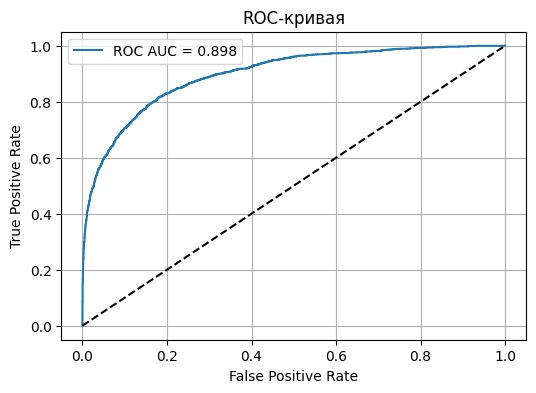

In [134]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = best_model.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)
auc = roc_auc_score(y, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)
plt.show()


Высокое значение ROC_AUC Кривой, говорит о том что намудалось создать модель, которая с достаточно высокой точностью предсказывет отток клиентов.

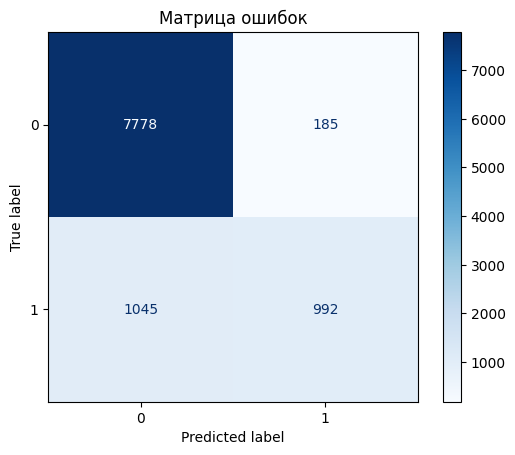

In [135]:
y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Матрица ошибок")
plt.show()

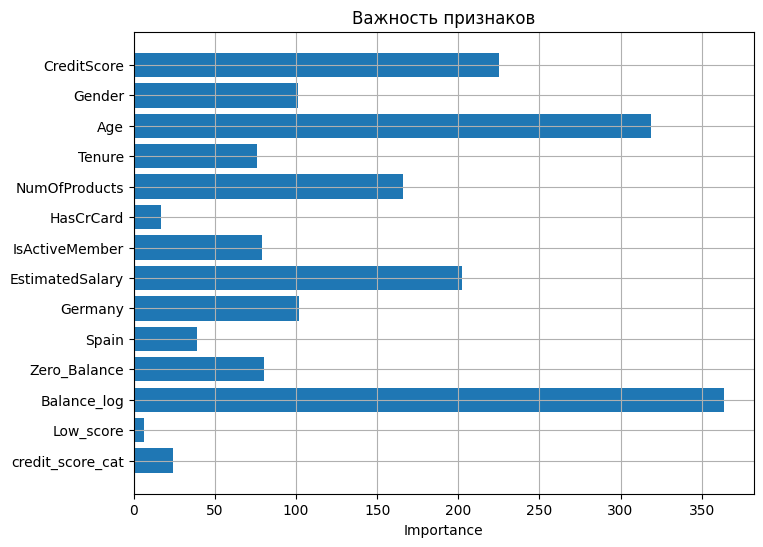

In [136]:
importances = best_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8, 6))
plt.barh(feat_names, importances)
plt.xlabel("Importance")
plt.title("Важность признаков")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


Итак самые значимые признаки это Estimated_Salary, Balance, Age и CreditScore.

Сохраняем лучшую модель

In [137]:
import joblib
joblib.dump(best_model, "churn_best_model.pkl")

['churn_best_model.pkl']

Делаем предсказание

In [138]:
X=churn_df.drop(['Geography', 'France', 'Exited'], axis=1)
# X=churn_df.drop(['Exited'], axis=1)

In [139]:
joblib.dump(best_model, "churn_best_model.pkl")

# Инференс
sample = X.sample(1, random_state=42)
proba = best_model.predict_proba(sample)[0][1]
print(f"Вероятность оттока для клиента: {proba:.2%}")

Вероятность оттока для клиента: 5.13%


In [142]:
!pip install shap
import shap

In [147]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

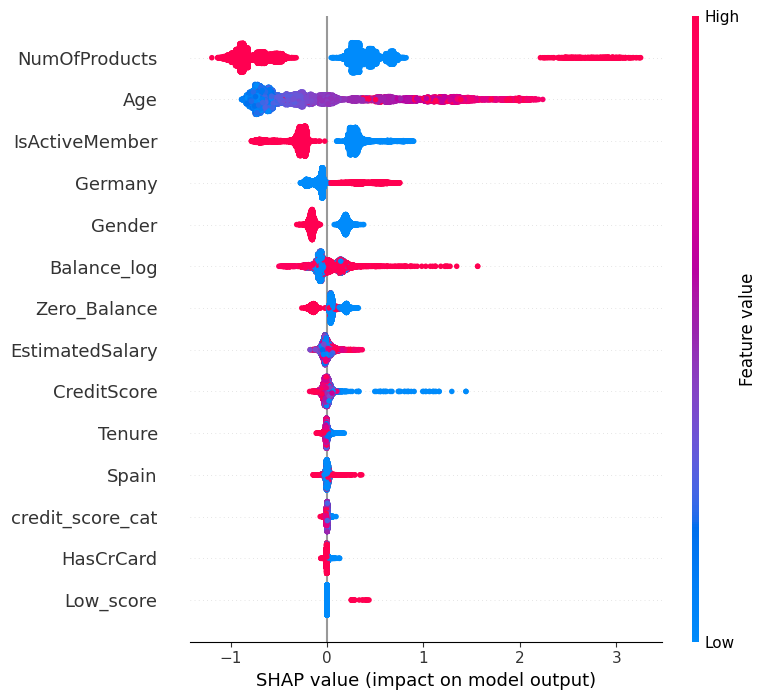

In [148]:
shap.summary_plot(shap_values, X, show=True)
plt.show()

plt.tight_layout()
plt.savefig("shap_summary.png")
plt.close()

Наиболее важные признаки:

* NumOfProducts: Количество используемых продуктов сильно влияет на отток увеличивая его.

* Age: Старший возраст связан с повышенной вероятностью оттока.

* IsActiveMember: Активность клиента также важна для модели, активные клиенты более склонны к оттоку.

SyntaxError: invalid character '📈' (U+1F4C8) (<ipython-input-146-3036979430>, line 11)

### Интерпретация результатов моделирования.


**1. NumOfProducts:** Чем меньше продуктов у клиента (синий), тем выше риск оттока. Здесь возникает интересная ситуация, когда SHAP-интерпретация кажется противоречущей фактическому распределению данных для групп с оттоком и без. Мы видим на графике что лояльные клиенты (не ушедшие) чаще всего имеют 2 продукта (оранжевые столбики) и чуть реже — 1 продукт (синие столбики), в то время как нелояльные (ушедшие) клиенты — в основном используют 1 продукт. 3 и 4 продукта — редки в наших наблюдениях, но клиенты с этими продуктами как правило покидают банк, особенно те у кого имеются 3 продукта. Получается, что среди нелояльных клиентов больше тех, кто ограничивается одним продуктом, либо у него много продуктов (перегретые или «загнанные» клиенты, у которых могли возникнуть проблемы с обслуживанием, нагрузкой, неудовлетворённостью.)

*Рекомендация: cross-sell дополнительные продукты для имеющих один продукт. Обращение пристального внимания на клиентов с 3-4 продуктами, возможно предложение альтернативных способов реструктурирования задолженности*



**2. Age:** Более возрастные клиенты (красный) чаще склонны к оттоку — модель это фиксирует. Возможная причина заключается в снижении интереса к банковским продуктам или более высокая клиентская насмотренность, осознанность формирующая  склонность к смене банка.

*Рекомендация: персонализированные предложения для возрастных клиентов.*



**3. IsActiveMember:** низкая активность (синий) увеличивает отток.

*Рекомендация: активационные кампании для повышения взаимодействия с банком.*



**4. Germany:** Признак указывает на то, что клиенты из Германии чаще уходят (SHAP положительный при значении 1). Возможная причина — географические различия в конкуренции, сервисе или культуре использования.

*Рекомендация: Анализ сервиса в регионе и разработка таргетированной программы лояльности*



**5. Gender:**
Женщины (если они кодированы как 1) чуть чаще склонны к оттоку, хотя эффект слабый.

*Рекомендвция: таргетировать retention-программы с учётом различиЙ*


**6. Balance_log / Zero_Balance**
Баланс имеет нелинейное влияние. У клиентов с нулевым балансом (Zero_Balance = 1) повышенный риск оттока.

*Рекомендация: работа с пустыми/спящими счетами, возможно, автоматические уведомления.*


**7. CreditScore**
При низком скоре (синий) вклад в отток повышается.

Интересно, что модель не делает большой акцент на скор — значит, он не является решающим для оттока.*

*Рекомендация: учитывать низкий рейтинг как фактор связаный с оттоком*


**8. Tenure:**
Клиенты с небольшим стажем в банке имеют слегка повышенную вероятность ухода.

*Рекомендация: программа лояльности/удержания в первые месяцы после открытия счёта.*




In [ ]:
## Заключение

## Заключение

На основании полученныйх данных были выявлены признаки влияющие на отток клиентов и построена модель LGBM для оценки риска оттока клиентов. Также была проведена интерпретация вклада признаков в

